In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import random
import shutil
from tensorflow import keras
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, MaxPool2D
from tensorflow.keras.optimizers import Adam
from google.colab import drive
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.models import load_model

In [ ]:
# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Define directories for data
data_dir = '/content/drive/MyDrive/Dog vs Cat/dogs-vs-cats'
train_dir = os.path.join(data_dir, 'train')
test_dir = os.path.join(data_dir, 'test1', 'all_images')

In [ ]:
# Define the directories for cats and dogs in the training set
cat_source_dir = os.path.join(train_dir, 'cats')
dog_source_dir = os.path.join(train_dir, 'dogs')

In [ ]:
# Create folders if they do not exist
if not os.path.exists(cat_source_dir):
    os.makedirs(cat_source_dir)
if not os.path.exists(dog_source_dir):
    os.makedirs(dog_source_dir)

In [ ]:
# Define image size and batch size
image_size = (224, 224)  # Change image size to 224x224
batch_size = 32

In [ ]:
# Function to sample images randomly from source directories
def sample_images(source_dir, num_images):
    image_files = [f for f in os.listdir(source_dir) if f.lower().endswith(('jpg', 'jpeg', 'png'))]
    random.shuffle(image_files)
    sampled_files = image_files[:num_images]
    return sampled_files

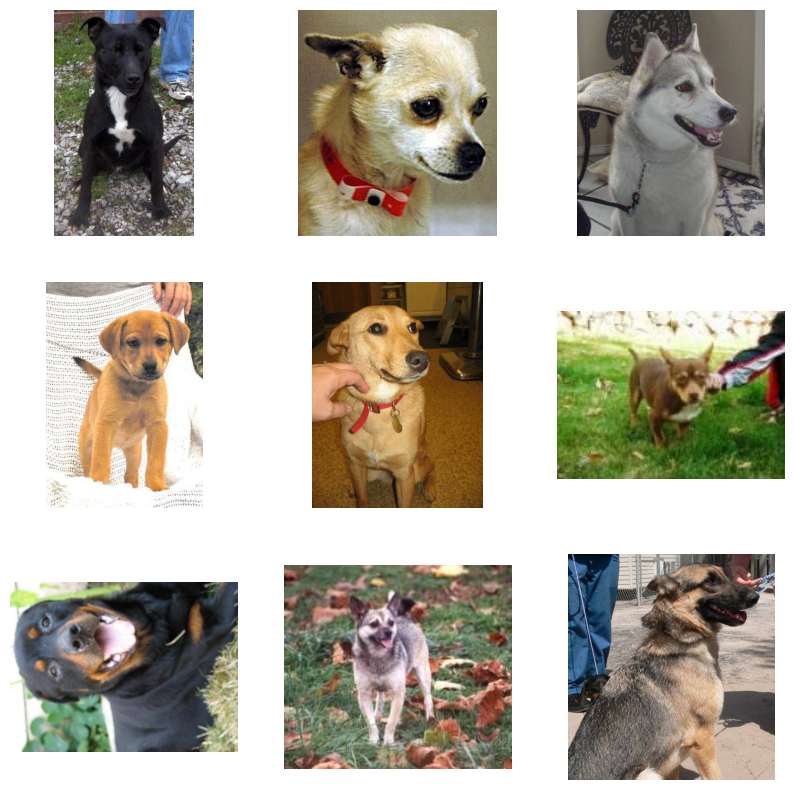

In [ ]:
dog_subfolder = os.path.join(data_dir, "train/dogs")

# Check the first 9 Dog Pictures
dog_image_files = os.listdir(dog_subfolder)

dog_images = []
for i in range(9):
    img_path = os.path.join(dog_subfolder, dog_image_files[i])
    img = image.load_img(img_path)
    img_array = image.img_to_array(img)
    img_array /= 255.0  # Normalize pixel values to [0, 1]
    dog_images.append(img_array)

# Display the images using matplotlib
fig, axes = plt.subplots(3, 3, figsize=(10, 10))
axes = axes.ravel()

for i in range(9):
    axes[i].imshow(dog_images[i])
    axes[i].axis('off')

plt.show()

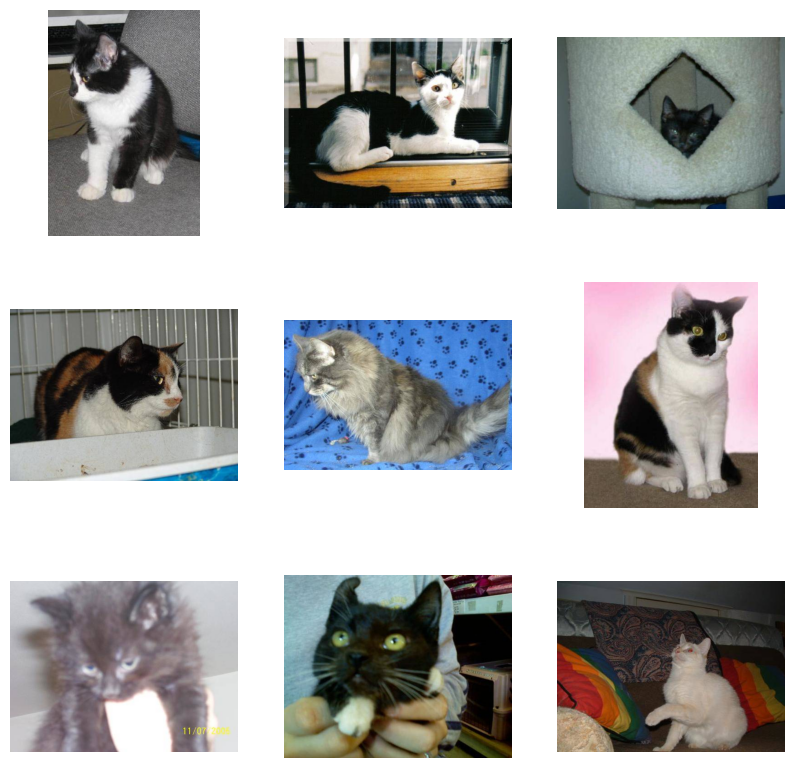

In [ ]:
cat_subfolder = os.path.join(data_dir, "train/cats")

# Check the first 9 Cat Pictures
cat_image_files = os.listdir(cat_subfolder)

cat_images = []
for i in range(9):
    img_path = os.path.join(cat_subfolder, cat_image_files[i])
    img = image.load_img(img_path)
    img_array = image.img_to_array(img)
    img_array /= 255.0  # Normalize pixel values to [0, 1]
    cat_images.append(img_array)

# Display the images using matplotlib
fig, axes = plt.subplots(3, 3, figsize=(10, 10))
axes = axes.ravel()

for i in range(9):
    axes[i].imshow(cat_images[i])
    axes[i].axis('off')

plt.show()

In [ ]:
# Number of images for training and testing
num_train_images = 1000  # Adjust based on available resources
num_test_images = 500

In [ ]:
# Get sampled cat and dog images for training
train_cat_images = sample_images(cat_source_dir, num_train_images // 2)
train_dog_images = sample_images(dog_source_dir, num_train_images // 2)

In [ ]:
# Function to create a generator with sampled images
def create_train_generator(train_cat_images, train_dog_images):
    # Temporary directory for the sampled training set
    temp_train_dir = '/content/temp_train'
    temp_cat_dir = os.path.join(temp_train_dir, 'cats')
    temp_dog_dir = os.path.join(temp_train_dir, 'dogs')

    # Make directories
    os.makedirs(temp_cat_dir, exist_ok=True)
    os.makedirs(temp_dog_dir, exist_ok=True)

    # Copy the sampled images to the temporary directories
    for img in train_cat_images:
        shutil.copy(os.path.join(cat_source_dir, img), os.path.join(temp_cat_dir, img))
    for img in train_dog_images:
        shutil.copy(os.path.join(dog_source_dir, img), os.path.join(temp_dog_dir, img))

    return temp_train_dir  # Return the temporary training directory path

In [ ]:
# Create ImageDataGenerator for training with augmentation
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255.0,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [ ]:
# Create the train generator
temp_train_dir = create_train_generator(train_cat_images, train_dog_images)

In [ ]:
# Create train generator with class_mode='binary'
train_generator = train_datagen.flow_from_directory(
    directory=temp_train_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode="binary",  # Ensure this is set to 'binary'
    shuffle=True
)

Found 1000 images belonging to 2 classes.


In [ ]:
# Sample test images
test_images = sample_images(test_dir, num_test_images)

In [ ]:
# Preprocess test images
test_image_arrays = []
for img_file in test_images:
    img_path = os.path.join(test_dir, img_file)
    img = image.load_img(img_path, target_size=image_size)
    img_array = image.img_to_array(img) / 255.0  # Normalize the image
    test_image_arrays.append(img_array)

In [ ]:
# Convert list to numpy array
test_data = np.array(test_image_arrays)
print(f"Loaded {len(test_data)} test images")
print(f"Shape of test data: {test_data.shape}")

Loaded 500 test images
Shape of test data: (500, 224, 224, 3)


In [ ]:
# Model architecture based on VGG16
model = Sequential()
model.add(Conv2D(input_shape=(224,224,3), filters=64, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=64, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Flatten())
model.add(Dense(units=4096, activation="relu"))
model.add(Dense(units=4096, activation="relu"))
model.add(Dense(units=1, activation="sigmoid"))  # Binary classification: 1 output neuron

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
# Add model saving and early stopping
checkpoint = ModelCheckpoint(filepath="/content/drive/MyDrive/Dog vs Cat/saved_models/vgg16_1.keras", save_best_only=True)
early_stopping = EarlyStopping(patience=3)

In [ ]:
# Fit the model
hist = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=10,  # Adjust epochs as needed
    callbacks=[checkpoint, early_stopping],
)

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


31/31 ━━━━━━━━━━━━━━━━━━━━ 2254s 72s/step - accuracy: 0.4777 - loss: 0.6939
Epoch 2/10


/usr/local/lib/python3.10/dist-packages/keras/src/callbacks/model_checkpoint.py:206: UserWarning: Can save best model only with val_loss available, skipping.
  self._save_model(epoch=epoch, batch=None, logs=logs)
/usr/local/lib/python3.10/dist-packages/keras/src/callbacks/early_stopping.py:155: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: accuracy,loss
  current = self.get_monitor_value(logs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 72s 2ms/step - accuracy: 0.5312 - loss: 0.6931  
Epoch 3/10


/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


31/31 ━━━━━━━━━━━━━━━━━━━━ 2264s 72s/step - accuracy: 0.5028 - loss: 0.6932
Epoch 4/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 71s 533us/step - accuracy: 0.4375 - loss: 0.6932
Epoch 5/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 2220s 71s/step - accuracy: 0.4648 - loss: 0.6932
Epoch 6/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 71s 480us/step - accuracy: 0.5625 - loss: 0.6931
Epoch 7/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 2208s 71s/step - accuracy: 0.5052 - loss: 0.6932
Epoch 8/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 72s 657us/step - accuracy: 0.4375 - loss: 0.6933
Epoch 9/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 2214s 71s/step - accuracy: 0.5103 - loss: 0.6932
Epoch 10/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 73s 657us/step - accuracy: 0.4062 - loss: 0.6940


In [ ]:
# Display model summary
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_12 (Conv2D)                   │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 4096)                │     102,764,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4096)                │      16,781,312 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 402,793,925 (1.50 GB)

 Trainable params: 134,264,641 (512.18 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 268,529,284 (1.00 GB)

In [ ]:
# Make predictions on the test data
predictions = model.predict(test_data)

16/16 ━━━━━━━━━━━━━━━━━━━━ 328s 20s/step


In [ ]:
# Display predictions
for i, pred in enumerate(predictions):
    label = 'Dog' if pred[0] > 0.5 else 'Cat'
    print(f"Image: {test_images[i]}, Prediction: {label}, Confidence: {pred[0]:.2f}")


Image: 2512.jpg, Prediction: Cat, Confidence: 0.50
Image: 9370.jpg, Prediction: Cat, Confidence: 0.50
Image: 4431.jpg, Prediction: Cat, Confidence: 0.50
Image: 2523.jpg, Prediction: Cat, Confidence: 0.50
Image: 5465.jpg, Prediction: Cat, Confidence: 0.50
Image: 4852.jpg, Prediction: Cat, Confidence: 0.50
Image: 10408.jpg, Prediction: Cat, Confidence: 0.50
Image: 2090.jpg, Prediction: Cat, Confidence: 0.50
Image: 6814.jpg, Prediction: Cat, Confidence: 0.50
Image: 4510.jpg, Prediction: Cat, Confidence: 0.50
Image: 11203.jpg, Prediction: Cat, Confidence: 0.50
Image: 9244.jpg, Prediction: Cat, Confidence: 0.50
Image: 885.jpg, Prediction: Cat, Confidence: 0.50
Image: 11427.jpg, Prediction: Cat, Confidence: 0.50
Image: 1378.jpg, Prediction: Cat, Confidence: 0.50
Image: 3813.jpg, Prediction: Cat, Confidence: 0.50
Image: 8034.jpg, Prediction: Cat, Confidence: 0.50
Image: 1453.jpg, Prediction: Cat, Confidence: 0.50
Image: 8058.jpg, Prediction: Cat, Confidence: 0.50
Image: 10896.jpg, Prediction:

dict_keys(['accuracy', 'loss'])


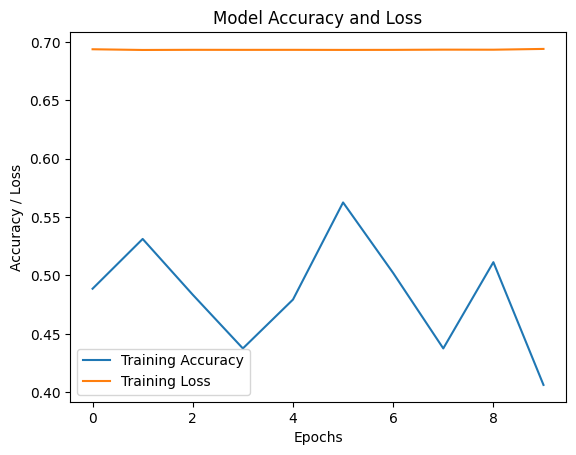

In [ ]:
# Print available metrics
print(hist.history.keys())

# Plot only available keys
plt.plot(hist.history["accuracy"], label="Training Accuracy")
if "val_accuracy" in hist.history:
    plt.plot(hist.history["val_accuracy"], label="Validation Accuracy")

plt.plot(hist.history["loss"], label="Training Loss")
if "val_loss" in hist.history:
    plt.plot(hist.history["val_loss"], label="Validation Loss")

plt.title("Model Accuracy and Loss")
plt.xlabel("Epochs")
plt.ylabel("Accuracy / Loss")
plt.legend()
plt.show()